In [19]:
import pandas
from scipy.stats import pearsonr, spearmanr
from scipy import mean, std
from math import log
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
%matplotlib inline

In [20]:
downsamples = ['1', '5', '10', '25', 'full']

I used the data from the paper "Single-cell RNA-seq analysis of human pancreas from healthy individuals and type 2 diabetes patients".


> We used single-cell RNA-sequencing to generate transcriptional profiles of endocrine and exocrine cell types of the human pancreas. Pancreatic tissue and islets were obtained from six healthy and four T2D cadaveric donors. Islets were cultured and dissociated into single-cell suspension. Viable individual cells were distributed via fluorescence-activated cell sorted (FACS) into 384-well plates containing lysis buffer. Single-cell cDNA libraries were generated using the Smart-seq2 protocol. Gene expression was quantified as reads per kilobase transcript and per million mapped reads (RPKM) using rpkmforgenes. Bioinformatics analysis was used to classify cells into cell types without knowledge of cell types or prior purification of cell populations. We revealed subpopulations in endocrine and exocrine cell types, identified genes with interesting correlations to body mass index (BMI) in specific cell types and found transcriptional alterations in T2D.

I was able to download 2081 cell datasets. The data is 8.1 Gb. The datasets' properties:

* RNA-Seq single-end reads, length = 43 bp

* Summary of the cell types:

| cell type                   | count |
|-----------------------------|-----|
| acinar cell                 | 175 |
| alpha cell                  | 829 |
| beta cell                   | 249 |
| co-expression cell          | 38  |
| delta cell                  | 104 |
| ductal cell                 | 380 |
| endothelial cell            | 15  |
| epsilon cell                | 7   |
| gamma cell                  | 183 |
| mast cell                   | 7   |
| MHC class II cell           | 5   |
| PSC cell                    | 54  |
| unclassified cell           | 2   |
| unclassified endocrine cell | 33  |


# Read the datasets into the memory

In [21]:
kallisto = {}
for ds in downsamples:
    kallisto[ds] = pandas.read_csv("output_kallisto4/%s.tsv" % ds, index_col=0)

# Read the cell types into the memory

In [22]:
cell_types = pandas.read_csv("CELL.TYPES.txt", header=None)

# Group the cells by cell types

In [23]:
cell_type_dict = {}
type_cell_dict = {}
for ctype, cell in zip(cell_types[0], cell_types[1]):
    cell_type_dict[cell] = ctype
    if ctype not in type_cell_dict:
        type_cell_dict[ctype] = []
    type_cell_dict[ctype].append(cell)

In [24]:
type_cell_df = {}

for ctype in type_cell_dict:
    ct = {}
    for ds in downsamples:
        ct[ds] = kallisto[ds][type_cell_dict[ctype]]
    type_cell_df[ctype] = ct

# Find mean gene expression for each cell type and each coverage

In [25]:
type_cell_mean = {}

for ctype in type_cell_dict:
    ct = {}
    for ds in downsamples:
        ct[ds] = type_cell_df[ctype][ds].mean(axis=1)
    type_cell_mean[ctype] = ct


In [26]:
type_cell_mean["delta cell"]["1"].sort_values(ascending=False).head()

SST           300624.038462
MTRNR2L12      16982.819038
AL512646.1     15818.760567
MT.CO1         15739.267308
MT.CO2         14783.629615
dtype: float64

# Check how many genes are missing in each of the cell types across all the cells

In [27]:
type_cell_missing = {}


for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        detected = 0
        allofthem = 0
        for x, y in zip(type_cell_mean[ctype][ds], type_cell_mean[ctype]["full"]):
            if y > 1:
                allofthem += 1
                if x > 1:
                    detected += 1
        corrs.append(detected * 1.0 / allofthem)
        type_cell_missing[ds] = corrs
    
    
type_cell_missing = pandas.DataFrame(type_cell_missing)
ctype_index2 = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index2[i] = ctype
type_cell_missing = type_cell_missing.rename(ctype_index2, axis='index')
type_cell_missing = type_cell_missing[downsamples]

# This many genes detected

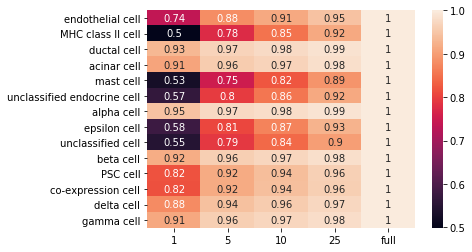

In [28]:
heatmap0 = sns.heatmap(type_cell_missing, annot=True)

# Spearman correlation between mean gene expression for each downsample and full dataset (for each coverage)

In [29]:
spearmans = {}

for ds in downsamples:
    corrs = []
    for ctype in type_cell_dict:
        corrs.append(spearmanr(type_cell_mean[ctype][ds], type_cell_mean[ctype]["full"])[0])
    spearmans[ds] = corrs
spearmans = pandas.DataFrame(spearmans)
ctype_index = {}
for i, ctype in enumerate(type_cell_dict):
    ctype_index[i] = ctype
spearmans = spearmans.rename(ctype_index, axis='index')
spearmans = spearmans[downsamples]

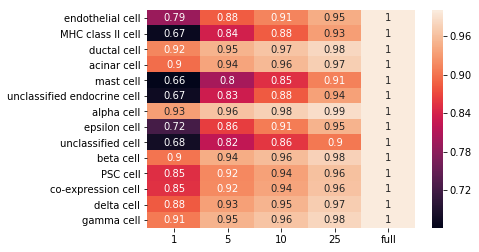

In [30]:
heatmap1 = sns.heatmap(spearmans, annot=True)

##### It can be clearly seen that for 1% downsample, cell types having more cells have higher correlation with the full dataset.

In [31]:
cell_counts = dict(map(lambda x: (x[0], len(x[1])), type_cell_dict.items()))

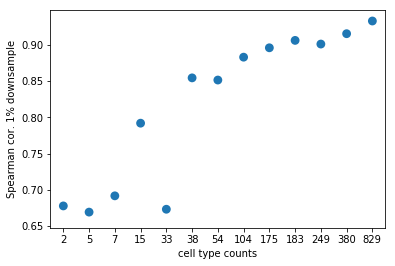

In [32]:
correlations_1 = dict(spearmans["1"])

cell_counts.values()
a = sns.pointplot(cell_counts.values(), correlations_1.values(), join=False, errwidth=0)
a.set(xlabel='cell type counts', ylabel='Spearman cor. 1% downsample')
plt.show()

# Distribution of Spearman correlation for each cell

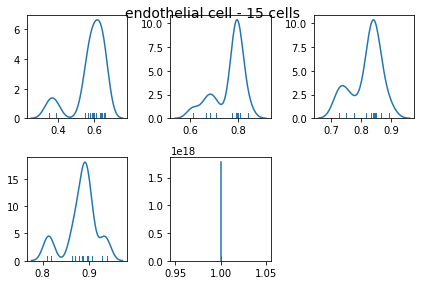

In [33]:
ctypes = type_cell_dict.keys()

i = 0
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

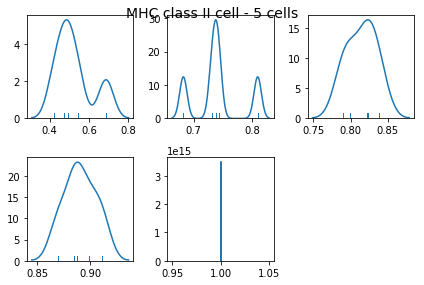

In [34]:
i = 1
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

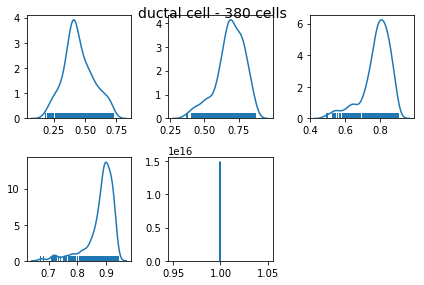

In [35]:
i = 2
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

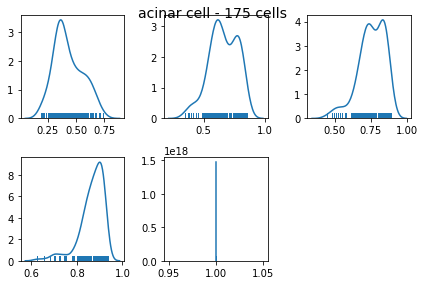

In [36]:
i = 3
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

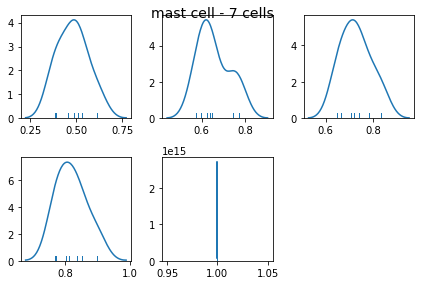

In [37]:
i = 4
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

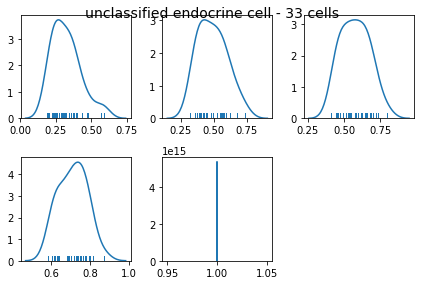

In [38]:
i = 5
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

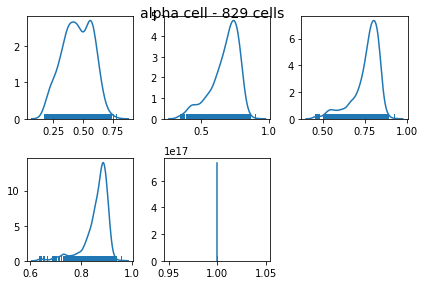

In [39]:
i = 6
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

/home/igorm/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/igorm/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/igorm/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


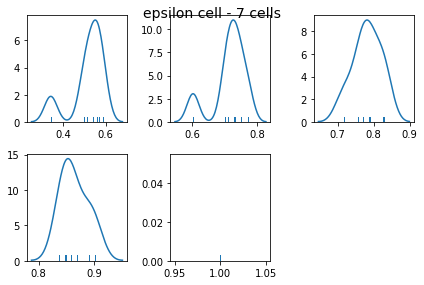

In [40]:
i = 7
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

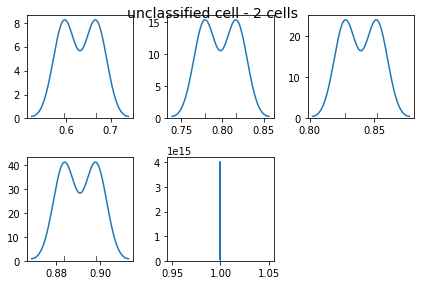

In [41]:
i = 8
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

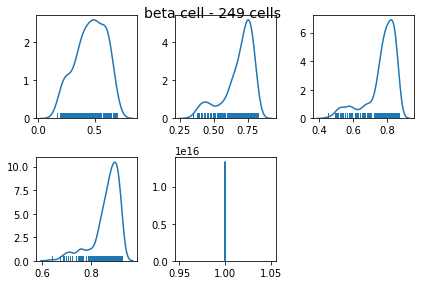

In [42]:
i = 9
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

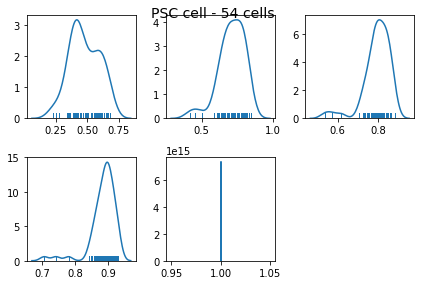

In [43]:
i = 10
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

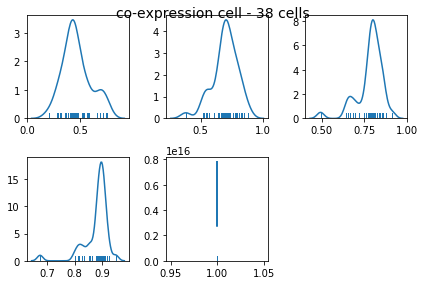

In [44]:
i = 11
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

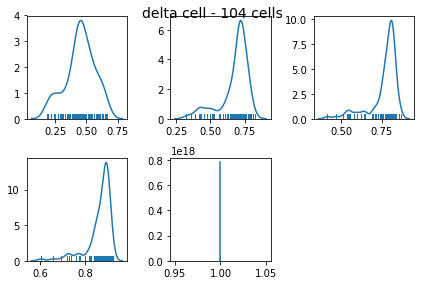

In [45]:
i = 12
ctype = ctypes[i]
clen = len(type_cell_dict[ctype])
spss = []
for ds in downsamples:
    columns = type_cell_df[ctype][ds].columns
    sps = []
    for column in columns:
        sc = spearmanr(type_cell_df[ctype][ds][column], type_cell_df[ctype]["full"][column])[0]
        sps.append(sc)
    spss.append(sps)

plt.suptitle("%s - %s cells" % (ctype, clen), fontsize=14, )
for i in range(len(spss)):
    plt.subplot(2, 3, i + 1)
    sns.distplot(spss[i], hist=False)
    sns.rugplot(spss[i])
    plt.tight_layout()
    

# Perform PCA and check the cell types clustering

In [49]:
full_data = kallisto["full"].transpose()
full_data_index = full_data.index
pca = PCA(n_components=2)
full_data = StandardScaler().fit_transform(full_data)
principalComponents = pca.fit_transform(full_data)

In [51]:
principalDf = pandas.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

celltypes = []
for i in range(len(full_data_index)):
    celltypes.append(cell_type_dict[full_data_index[i]])
    
# attach the cell type
principalDf["cell type"] = celltypes

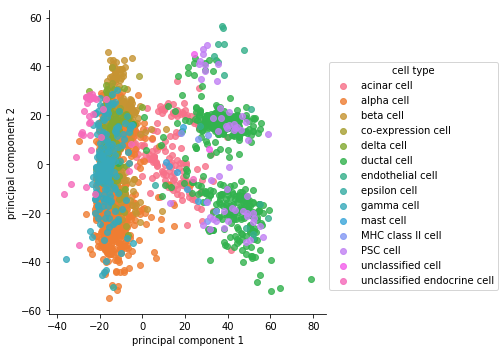

In [52]:
principalDf
pca_plot = sns.lmplot('principal component 1', 'principal component 2', data=principalDf, fit_reg=False, hue="cell type")